# __LAB 4__
### Q1

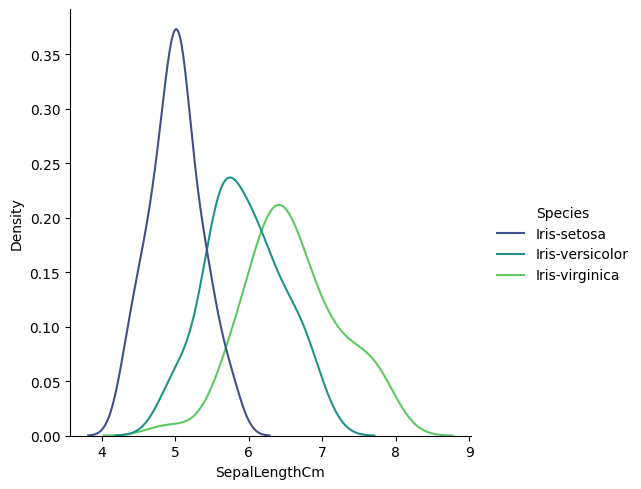

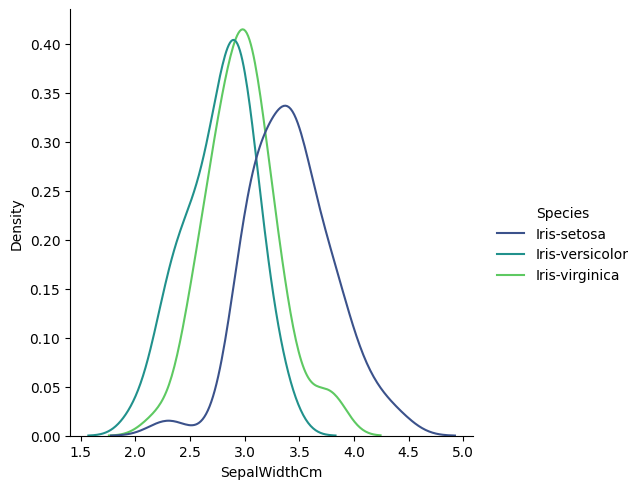

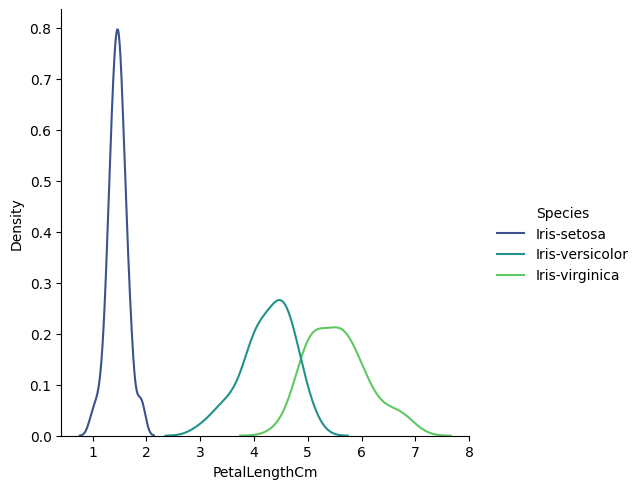

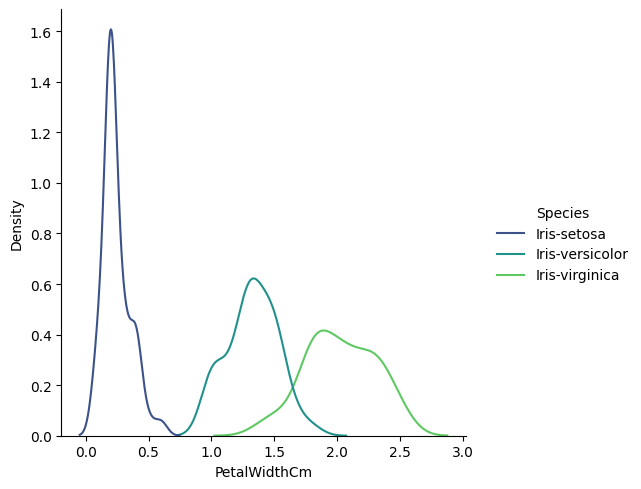

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numpy import linalg as LA
from scipy.linalg import fractional_matrix_power
from sklearn.inspection import DecisionBoundaryDisplay
import math

data  = pd.read_csv("./Iris.csv")
data.drop(columns="Id", inplace=True, axis=1)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


y = data["Species"]
X = data.drop(columns= "Species").copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

sns.displot(data=data, x='SepalLengthCm', hue='Species', kind='kde', palette="viridis")
sns.displot(data=data, x='SepalWidthCm', hue='Species', kind='kde',palette="viridis")
sns.displot(data=data, x='PetalLengthCm', hue='Species', kind='kde', palette="viridis")
sns.displot(data=data, x='PetalWidthCm', hue='Species', kind='kde', palette="viridis")

le = LabelEncoder()
data["Species"] = le.fit_transform(data["Species"])


In [2]:
class GaussianNB:
  def __init__(self, case=3) -> None:
    self.case = case
    self.prior = None
    self.classes = None
    self.target_col = None
    self.mean = []
    self.sigma = []
    self.class_counts = []
    
  def train(self, x_train, y_train):
    self.class_counts = np.array(y_train.value_counts())
    self.prior = np.round(y_train.value_counts() / len(y_train), 2)
    self.classes = y_train.unique()

    # finding means and sigma of all columns for each class 
    df = pd.concat([x_train, y_train], axis=1)
    self.target_col = df.columns[-1]

    for cls in self.classes:
      mean_i = []
      filtered = df[df[self.target_col] == cls].copy()
      features = filtered.drop(columns=[self.target_col], axis=1)
      sigma_i = np.round(np.array(features.cov()), 3)
      self.sigma.append(sigma_i)

      for col in filtered.columns:
        if(col != self.target_col):
          mean_i.append(round(filtered[col].mean(axis=0), 4))
      self.mean.append(mean_i)

    self.mean = np.array(self.mean)
    self.sigma = np.array(self.sigma)

    if self.case == 2:
      pooled_matrix = np.zeros(shape=(self.sigma.shape[1], self.sigma.shape[1]))
      for i in range(len(self.classes)):
        pooled_matrix += (self.class_counts[i] -1)*self.sigma[i]
      factor = len(y_train) - len(self.classes)
      pooled_matrix = np.round((1/factor) * pooled_matrix, 4)      
      for i in range(len(self.classes)):
        self.sigma[i] = pooled_matrix

    if self.case == 1:
      id_mat = np.identity(self.sigma.shape[1])
      for i in range(len(self.classes)):
        self.sigma[i] = id_mat



  def posterior(self, x, cls_idx):
    # calculating likelihood
    a = np.array((x-self.mean[cls_idx]))
    res = np.matmul(a.T, np.linalg.inv(self.sigma[cls_idx]))
    res = np.exp(np.matmul(res, a) * (-0.5))
    factor = np.round(1/((2*np.pi)**(self.sigma.shape[1]/2) * np.sqrt(np.linalg.det(self.sigma[cls_idx]))), 4)
    likelihood = factor * res

    # posterior = likelihood * prior 
    posterior = np.round(likelihood * self.prior[self.classes[cls_idx]], 4)
    return posterior

  def predict(self, x):
    max_prob = -float('inf')
    optimal = 0
    for i in range(len(self.classes)):
      current_posterior_prob = self.posterior(x, i)
      if current_posterior_prob > max_prob:
        max_prob = current_posterior_prob
        optimal = i
    return self.classes[optimal]

  
  def test(self, x_test):
    y_preds = []
    x_test = pd.DataFrame(x_test)
    for row in x_test.iterrows():
      row = np.array(row[1])
      y_preds.append(self.predict(row))
    return y_preds

  def accuracy(self, y_preds, y_test):
    acc = 0
    y_preds = np.array(y_preds)
    y_test = np.array(y_test)
    for i in range(len(y_test)):
      if(y_test[i] == y_preds[i]):
        acc += 1
    return np.round(acc/len(y_test), 4)



  def posterior_db(self, x, cls_idx):
    # calculating likelihood
    mean_fil = self.mean[:, :2]
    sigma_fil = self.sigma[:, :2, :2]
    a = np.array((x-mean_fil[cls_idx]))
    res = np.matmul(a.T, np.linalg.inv(sigma_fil[cls_idx]))
    res = np.exp(np.matmul(res, a) * (-0.5))
    factor = np.round(1/((2*np.pi)**(sigma_fil.shape[1]/2) * np.sqrt(np.linalg.det(sigma_fil[cls_idx]))), 4)
    likelihood = factor * res

    # posterior = likelihood * prior 
    posterior = np.round(likelihood * self.prior[self.classes[cls_idx]], 4)
    return posterior

  def predict__db(self, x):
    max_prob = -float('inf')
    optimal = 0
    for i in range(len(self.classes)):
      current_posterior_prob = self.posterior_db(x, i)
      if current_posterior_prob > max_prob:
        max_prob = current_posterior_prob
        optimal = i
    return self.classes[optimal]


  def plot_decision_boundary(self, x_train, y_train):
    map = {}
    for i in range(len(self.classes)):
      map[self.classes[i]] = i
    y_train_copy = np.array(y_train)
    for i in range(len(y_train_copy)):
      y_train_copy[i] = map[y_train_copy[i]] 

    
    mean_fil = self.mean[:, :2]
    sigma_fil = self.sigma[:, :2, :2]
    h = 0.02
    x_min, x_max = x_train[x_train.columns[0]].min() - 10*h, x_train[x_train.columns[0]].max() + 10*h
    y_min, y_max = x_train[x_train.columns[1]].min() - 10*h, x_train[x_train.columns[1]].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    X_preds = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    y_preds = []
    for row in X_preds.iterrows():
      row = np.array(row[1])
      y_preds.append(self.predict__db(row))

    for i in range(len(y_preds)):
      y_preds[i] = map[y_preds[i]] 
    y_preds = np.array(y_preds).reshape(xx.shape)

    # print(y_preds)

    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, y_preds,  alpha=0.25)
    plt.contour(xx, yy, y_preds, colors='k', linewidths=0.7)
    plt.scatter(x_train[x_train.columns[0]], x_train[x_train.columns[1]], c=y_train_copy, edgecolors='k')
    



0.9778


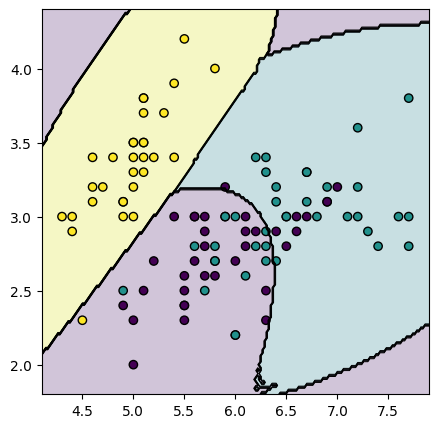

In [3]:
gnb = GaussianNB(case=3)
gnb.train(X_train, y_train)
y_preds = gnb.test(X_test)
print(gnb.accuracy(y_preds, y_test))

gnb.plot_decision_boundary(X_train, y_train)


1.0


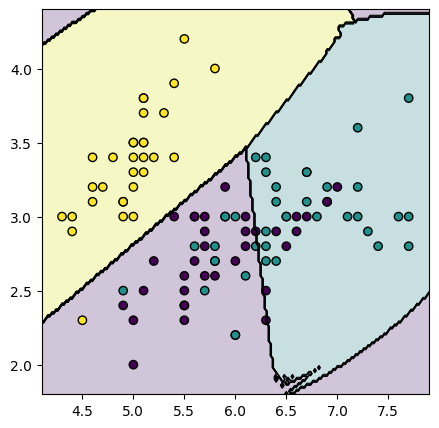

In [4]:
gnb2 = GaussianNB(case=2)
gnb2.train(X_train, y_train)
y_preds = gnb2.test(X_test)
print(gnb2.accuracy(y_preds, y_test))

gnb2.plot_decision_boundary(X_train, y_train)

0.9556


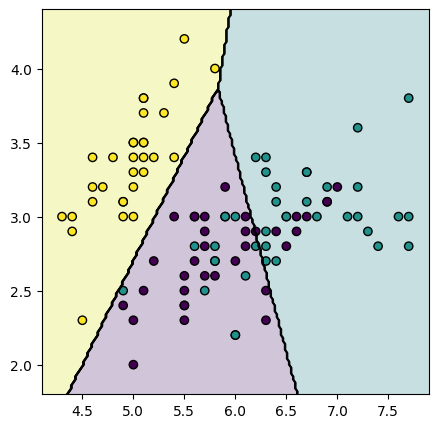

In [5]:
gnb1 = GaussianNB(case=1)
gnb1.train(X_train, y_train)
y_preds = gnb1.test(X_test)
print(gnb1.accuracy(y_preds, y_test))

gnb1.plot_decision_boundary(X_train, y_train)

In [6]:
k = 5
size = math.floor(X_train.shape[0]/k)

cross_val_scores = []
for i in range(k):
  x_valid = X_train[size*i:(i+1)*size]
  y_valid = y_train[size*i:(i+1)*size]

  X_train_1 = X_train[0: size*i]
  X_train_2 = X_train[(i+1)*size:]
  y_train_1 = y_train[0: size*i]
  y_train_2 = y_train[(i+1)*size:]
  X_train_new = pd.concat([X_train_1, X_train_2], axis=0)
  y_train_new = pd.concat([y_train_1, y_train_2], axis=0)

  my_model = GaussianNB()
  my_model.train(X_train_new, y_train_new)
  ypreds = my_model.test(x_valid)
  cross_val_scores.append(my_model.accuracy(ypreds, y_valid))

print("5 fold Cross Validation Scores:")
print(cross_val_scores)
print("Mean: {}".format(np.array(cross_val_scores).mean()))


5 fold Cross Validation Scores:
[0.9524, 1.0, 0.8571, 1.0, 1.0]
Mean: 0.9619


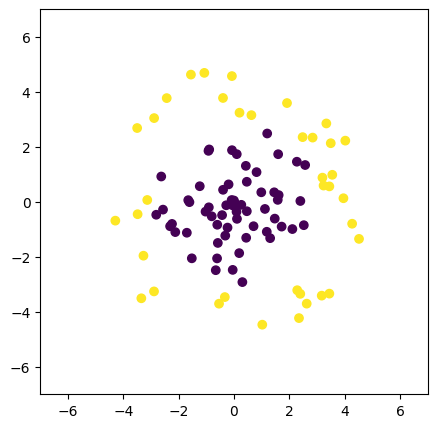

In [7]:
theta = np.random.rand(100) * 2*np.pi
r = np.random.rand(100)* 5

x1 = pd.Series(r*np.cos(theta))
x2 = pd.Series(r*np.sin(theta))
y = pd.Series(np.ones(100))

for i in range(len(y)):
  euc_dis = np.sqrt(np.square(x1[i]) + np.square(x2[i])) 
  if(euc_dis > 3 and euc_dis<=5):
    y[i] = 2

df =pd.concat([x1, x2, y], axis=1)
df.columns = ["X1", "X2", "Y"]



plt.figure(figsize=(5, 5))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.scatter(x1, x2, c=df["Y"])



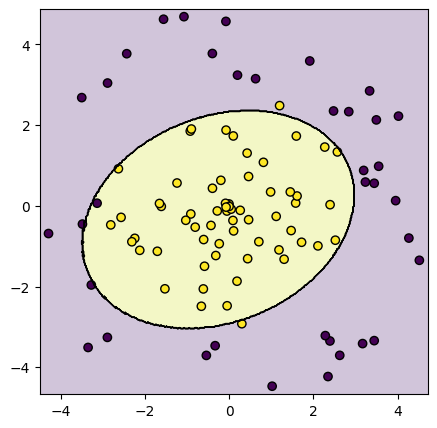

In [8]:
from sklearn.model_selection import train_test_split
X = df[["X1", "X2"]]
y = df["Y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

gnb_model = GaussianNB(3)
gnb_model.train(X, y)
gnb_model.plot_decision_boundary(X,y)

## Q2.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numpy import linalg as LA
from scipy.linalg import fractional_matrix_power



n = 200
sigma = [[1.5, 0.5], [0.5, 1.5]]
mean = [0, 0]

np.random.seed(4)
x, y = np.random.multivariate_normal(mean, sigma, n).T

random_indices = np.random.permutation(range(200))[:100]

sampled_x = []
sampled_y = []
for i in range(len(random_indices)):
  sampled_x.append(x[random_indices[i]])
  sampled_y.append(y[random_indices[i]])






The covariance matrix of sample is: 
[[0.75017007 0.26319247]
 [0.26319247 0.68781171]]


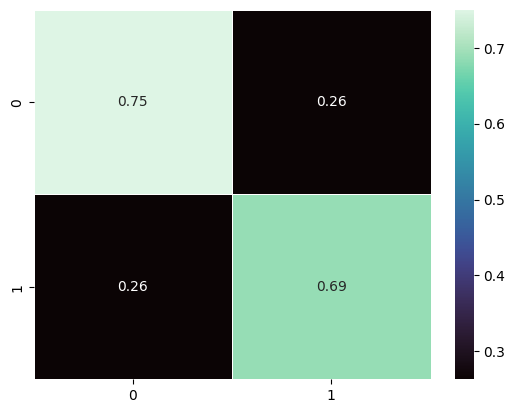

The eigenvalues are: 0.9840237496691742, 0.4539580305777433
The eigenvecotrs are: 
 [ 0.74754354 -0.66421281] and  
 [0.66421281 0.74754354]


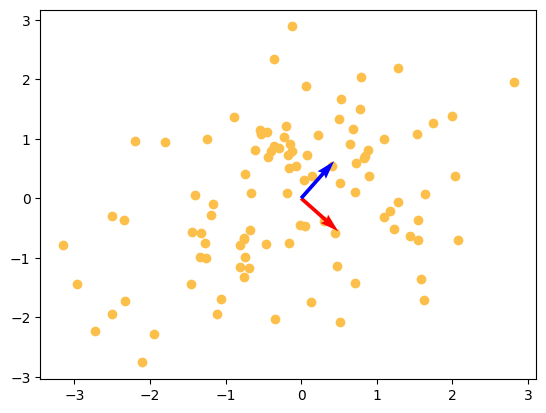

In [10]:
def mean(x):
  sum = 0
  for i in range(len(x)):
    sum += x[i]
  return sum/len(x)

def cov(x, y):
  x_mean = mean(x)
  y_mean = mean(y)
  sum = 0
  for i in range(len(x)):
    sum += (x[i] - x_mean)*(y[i]-y_mean)
  return sum/(n-1)

cov_xx = cov(sampled_x, sampled_x)
cov_xy = cov(sampled_x, sampled_y)
cov_yy = cov(sampled_y, sampled_y)

cov_matrix = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])
print("The covariance matrix of sample is: ")
print(cov_matrix)

ax = sns.heatmap(cov_matrix, linewidth=0.5, cmap="mako", annot=True)
plt.show()

w, v = LA.eig(cov_matrix)
print("The eigenvalues are: {}, {}".format(w[0], w[1]))
print("The eigenvecotrs are: \n {} and  \n {}".format(v[0], v[1]))

origin = [0, 0]

plt.scatter(sampled_x, sampled_y, c="#fcbf49")
plt.quiver(*origin, *v[0], color=['r'], scale=10)
plt.quiver(*origin, *v[1], color=['b'], scale=10)
plt.show()





[[1.00000000e+00 4.57478834e-17]
 [4.57478834e-17 1.00000000e+00]]
The eigenvalues are: 1.0000000000000002, 0.9999999999999993
The eigenvecotrs are: 
 [ 1.         -0.05143935] and  
 [0.         0.99867612]


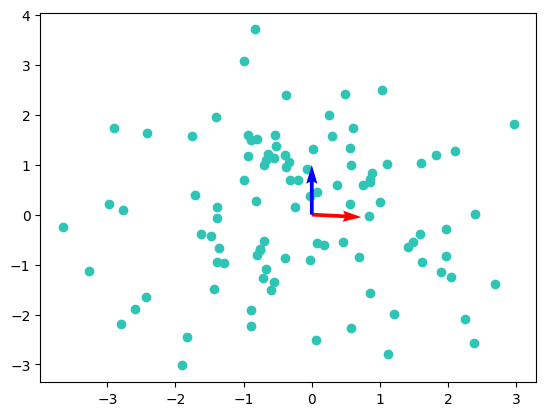

In [11]:
sampled_x = np.array(sampled_x).T
sampled_y = np.array(sampled_y).T

X = []
for i in range(len(sampled_x)):
  X.append([])
  X[i].append(sampled_x[i])
  X[i].append(sampled_y[i])


sigma_new = fractional_matrix_power(cov_matrix, -0.5)
X  = np.matrix(X)
# print(X, end="\n\n\n")
Y = pd.DataFrame(np.matmul(X, sigma_new))



col1 = Y.iloc[:, 0].tolist()
col2 = Y.iloc[:, 1].tolist()


cov_11 = cov(col1, col1)
cov_12 = cov(col1, col2)
cov_22 = cov(col2, col2)


# cov_matrix = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])
new_cov_matrix = np.zeros((2,2) )
new_cov_matrix[0][0]= cov_11
new_cov_matrix[0][1]= cov_12
new_cov_matrix[1][0]= cov_12
new_cov_matrix[1][1]= cov_22

print(new_cov_matrix)


w, v = LA.eig(new_cov_matrix)
print("The eigenvalues are: {}, {}".format(w[0], w[1]))
print("The eigenvecotrs are: \n {} and  \n {}".format(v[0], v[1]))

origin = [0, 0]



plt.scatter(col1, col2,  c = "#2ec4b6")
plt.quiver(*origin, *v[0], color=['r'], scale=10)
plt.quiver(*origin, *v[1], color=['b'], scale=10)





<BarContainer object of 10 artists>

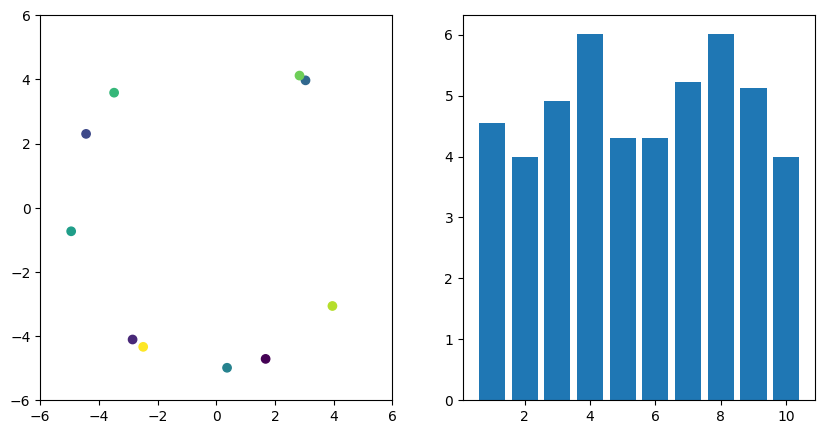

In [12]:
import math
# np.random.seed(10)
a = np.random.uniform(low=0, high=2*math.pi, size=10)

x = 5 * np.cos(a)
y = 5 * np.sin(a)
clr = np.linspace(0, 100, 10)

def mean(x):
  sum = 0
  for i in range(len(x)):
    sum += x[i]
  return sum/len(x)
  
def eucledian_dis(x, y):
  res = 0
  for i in range(len(x)):
    res += (x[i] - y[i])**2
  return res**0.5

u = [mean(x), mean(y)]
dis = []
for i in range(len(x)):
  vec = [x[i], y[i]]
  dis.append(eucledian_dis(vec, u))


figure, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].scatter(x, y, c=clr)
ax[0].set_xlim(-6, 6)
ax[0].set_ylim(-6, 6)
ax[1].bar(np.arange(1,11), dis)



<BarContainer object of 10 artists>

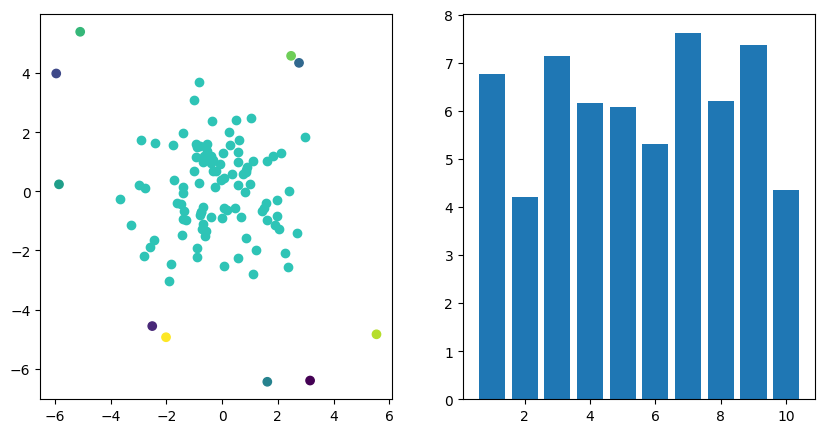

In [13]:
sigma_s = cov_matrix

P = []
for i in range(10):
  P.append([x[i], y[i]])
P = np.matrix(P)

Q = np.matmul(P, fractional_matrix_power(cov_matrix, -0.5)).tolist()
x = [i[0] for i in Q]
y = [i[1] for i in Q]

dis = []
for i in range(len(x)):
  vec = [x[i], y[i]]
  dis.append(eucledian_dis(vec, u))

figure, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].scatter(x, y, c=clr)
ax[0].scatter(col1, col2,  c = "#2ec4b6" )
# ax[0].set_xlim(-6, 6)
# ax[0].set_ylim(-6, 6)
ax[1].bar(np.arange(1,11), dis)







